<a href="https://colab.research.google.com/github/Jiale-jay/EEN1072-Data-Analysis-Machine-Learning-II-/blob/main/Task_Q1_Convolutional_Neural_Networks_(CNN)_for_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Link：https://colab.research.google.com/drive/1boP9vDiMgqMX2xq2Ks57LgXOJuEMp6_A?usp=sharing

##  The primary dataset used in this experiment is the Pascal VOC2007 dataset, which is available via TensorFlow Datasets (TFDS). This dataset is a well-established benchmark in the field of computer vision and object detection.

For this experiment, we focus solely on images that contain the "person" class. This selective approach helps simplify the problem and allows us to concentrate on a single category for object detection.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import random

# Set the random seed for reproducibility so that the results remain consistent across runs.
tf.random.set_seed(42)
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## Data Loading and Preprocessing

80% of the dataset is used for training the model.
20% of the dataset is reserved for testing, which will be used to evaluate the model’s performance on unseen data.

Additionally, a portion of the training set (e.g., 20% of the training data) can be set aside as a validation set. This validation set is used during the training process to monitor the model’s performance and to fine-tune hyperparameters.

The preprocessing steps include loading the dataset, filtering the samples, resizing images, normalizing pixel values, and converting bounding box annotations.

In [ ]:
# Data Loading and Preprocessing
# This block uses TensorFlow Datasets (TFDS) to load the Pascal VOC2007 dataset.
# The dataset is split into training (80%) and testing (20%) sets.
(ds_train, ds_test), ds_info = tfds.load(
    'voc/2007',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    shuffle_files=True
)

# Print the dataset information to help understand the data structure and for documentation.
print(ds_info)

# Retrieve the list of all object class names in the VOC dataset
# (e.g., "person", "dog", "cat", etc.). This will be used for filtering and labeling.
label_names = ds_info.features['objects']['label'].names
print("VOC Labels:", label_names)

# Define a filter function that keeps only the samples which contain the "person" object.
def filter_person(example):
    # Check if any of the labels in the sample equals the index corresponding to "person".
    # tf.reduce_any returns True if any element of the condition is True.
    return tf.reduce_any(tf.equal(example['objects']['label'], label_names.index("person")))

# Apply the filter function to both the training and testing datasets,
# so that only samples containing the "person" class remain.
ds_train = ds_train.filter(filter_person)
ds_test = ds_test.filter(filter_person)

# Define a preprocessing function to transform each sample:
# 1. Resize the image to 128x128 pixels.
# 2. Normalize the pixel values to the [0, 1] range.
# 3. From the available bounding boxes in the sample, select the first "person" object's bounding box.
# 4. Convert the bounding box format from [ymin, xmin, ymax, xmax] to [center_x, center_y, width, height].
def preprocess(example):
    # Resize the image to 128x128.
    image = tf.image.resize(example['image'], (128, 128))
    # Cast the image to float32 and normalize pixel values to the range [0, 1].
    image = tf.cast(image, tf.float32) / 255.0

    # Retrieve all bounding boxes for the objects in the image.
    bboxes = example['objects']['bbox']  # Original format: [ymin, xmin, ymax, xmax]
    labels = example['objects']['label']

    # Find indices where the label equals "person".
    person_indices = tf.where(tf.equal(labels, label_names.index("person")))
    person_indices = tf.squeeze(person_indices, axis=1)

    # Choose the first "person" bounding box. Since we've filtered the dataset,
    # at least one "person" object exists per sample.
    bbox = tf.cond(
        tf.size(person_indices) > 0,
        lambda: bboxes[person_indices[0]],
        lambda: tf.constant([0.0, 0.0, 0.0, 0.0])
    )

    # Convert the bounding box from [ymin, xmin, ymax, xmax] to [center_x, center_y, width, height].
    ymin, xmin, ymax, xmax = tf.unstack(bbox)
    cx = (xmin + xmax) / 2.0  # Compute center x-coordinate.
    cy = (ymin + ymax) / 2.0  # Compute center y-coordinate.
    w = xmax - xmin         # Compute width.
    h = ymax - ymin         # Compute height.
    bbox_converted = tf.stack([cx, cy, w, h])

    # Return the preprocessed image and the converted bounding box.
    return image, bbox_converted

# Set the batch size for training.
batch_size = 32

# Build the data pipeline for the training set:
# 1. Map each sample through the preprocess function.
# 2. Cache the dataset to speed up data retrieval.
# 3. Shuffle the data (with a buffer size of 1000).
# 4. Batch the data.
# 5. Prefetch to improve training performance.
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# The testing set undergoes similar preprocessing and batching, but shuffling is not required.
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Data preprocessing completed.")


tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_dir='/root/tensorflow_datasets/voc/2007/4.0.0',
    file_format=tfrecord,
    download_size=8

## Building the Convolutional Neural Network Model

In [ ]:
# Import necessary modules from TensorFlow's Keras API for constructing the model.
from tensorflow.keras import layers, models

def build_model():
    """
    This function builds a simple Convolutional Neural Network (CNN) for regressing
    the bounding box parameters of a detected object. The model takes an input image
    of size 128x128 with 3 color channels and outputs 4 continuous values representing
    [center_x, center_y, width, height] of the bounding box.
    """
    model = models.Sequential([
        # First Convolutional Layer:
        # - Uses 32 filters with a kernel size of 3x3.
        # - Applies the ReLU activation function.
        # - The input shape is specified as 128x128x3 (height, width, channels).
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),

        # First Pooling Layer:
        # - Uses Max Pooling to reduce the spatial dimensions by a factor of 2.
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Layer:
        # - Uses 64 filters with a 3x3 kernel.
        # - This layer extracts deeper features from the input.
        layers.Conv2D(64, (3, 3), activation='relu'),

        # Second Pooling Layer:
        # - Applies Max Pooling to further reduce the spatial dimensions.
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Layer:
        # Uses 128 filters with a 3x3 kernel.
        # This layer further captures more complex features.
        layers.Conv2D(128, (3, 3), activation='relu'),

        # Third Pooling Layer:
        # Uses Max Pooling to reduce the spatial dimensions once more.
        layers.MaxPooling2D((2, 2)),

        # Flatten Layer:
        # Flattens the 3D feature maps into a 1D vector to feed into the dense layers.
        layers.Flatten(),

        # Fully Connected (Dense) Layer:
        # Contains 128 neurons.
        # Helps in learning high-level representations from the flattened features.
        layers.Dense(128, activation='relu'),

        # Output Layer:
        # Contains 4 neurons corresponding to the bounding box parameters:
        #   [center_x, center_y, width, height].
        # No activation function is used here because we are performing regression,
        # and the output values can be any continuous number.
        layers.Dense(4)
    ])
    return model

# Create the model using the defined function.
model = build_model()

# Output the model summary to display the architecture, layer types, output shapes, and the number of parameters.
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the Model

In [ ]:

# Regression training using Adam optimiser and mean square error (MSE) loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse')

# Train the model, train 10 epochs and use the test set as a validation set
epochs = 10
history = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.5873 - val_loss: 0.0728
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0653 - val_loss: 0.0516
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0521 - val_loss: 0.0490
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0483 - val_loss: 0.0494
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0479 - val_loss: 0.0465
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0450 - val_loss: 0.0482
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0432 - val_loss: 0.0483
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0353 - val_loss: 0.0450
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0335 - val_loss: 0.0461
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0286 - val_loss: 0.0457


## Evaluate the Model and Visualize Predictions

This code block evaluates the trained model's performance on unseen test data by visually comparing the predicted bounding boxes to the true ones. First, a single batch of test images and their corresponding bounding boxes is extracted using .take(1), ensuring that only one batch is processed for evaluation. The model’s predict() function is then applied to these images, producing predicted bounding box parameters in the same format as the ground truth ([center_x, center_y, width, height]). Next, five images are randomly selected from this batch to avoid bias, and for each image, the true bounding box is converted from normalized coordinates to pixel coordinates ([xmin, ymin, xmax, ymax]) and drawn as a green rectangle. Similarly, the predicted bounding box is converted and drawn as a red rectangle. These subplots, each titled with the sample index, are arranged side by side to provide a clear, visual comparison.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


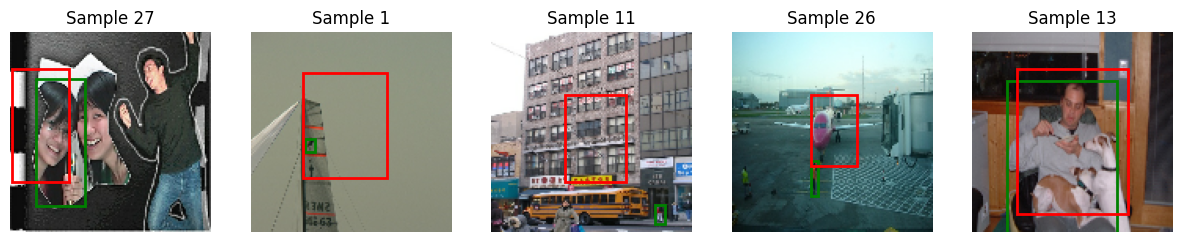

In [ ]:
# Retrieve one batch of test images and true bounding boxes from the test dataset.
for images, true_bboxes in ds_test.take(1):
    # Use the trained model to predict bounding box parameters on the batch of images.
    preds = model.predict(images)
    break  # Only process one batch

# Select a random sample of 5 images from the batch for visualization.
num_images = 5
indices = random.sample(range(images.shape[0]), num_images)

# Set up a figure to display the images.
plt.figure(figsize=(15, 3))

# Loop over the selected indices to plot each image and its bounding boxes.
for i, idx in enumerate(indices):
    # Create a subplot for each image.
    ax = plt.subplot(1, num_images, i+1)
    # Display the image.
    plt.imshow(images[idx])

    # Convert the true bounding box from the format [center_x, center_y, width, height]
    # to the format [xmin, ymin, xmax, ymax] for drawing.
    cx, cy, w, h = true_bboxes[idx].numpy()
    xmin = (cx - w/2) * 128  # Convert normalized coordinate to pixel value
    ymin = (cy - h/2) * 128
    xmax = (cx + w/2) * 128
    ymax = (cy + h/2) * 128
    # Create a green rectangle for the true bounding box.
    rect_true = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                              fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect_true)

    # Similarly, convert the predicted bounding box to [xmin, ymin, xmax, ymax].
    pcx, pcy, pw, ph = preds[idx]
    pxmin = (pcx - pw/2) * 128
    pymin = (pcy - ph/2) * 128
    pxmax = (pcx + pw/2) * 128
    pymax = (pcy + ph/2) * 128
    # Create a red rectangle for the predicted bounding box.
    rect_pred = plt.Rectangle((pxmin, pymin), pxmax - pxmin, pymax - pymin,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect_pred)

    # Set the title of the subplot indicating the sample index.
    ax.set_title(f"Sample {idx}")
    ax.axis('off')  # Remove axis ticks for clarity
plt.show()

## Visualize Training History
This code block is designed to visualize the training process of the model by plotting the loss curves for both training and validation sets over each epoch.

By examining the plotted loss curves, one can assess how well the model is learning over time.

## Improvement Scheme 1 – Building a Deeper Network

By increasing the number of convolutional layers and filters to build a deeper network, it is hoped that the model will be able to extract more complex and richer image features, thereby improving the regression accuracy of the target bounding box.

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,748,996 (10.49 MB)

 Trainable params: 2,748,996 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

Training the deeper network model...
Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 0.4546 - val_loss: 0.0546
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0560 - val_loss: 0.0492
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0514 - val_loss: 0.0456
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0478 - val_loss: 0.0449
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0452 - val_loss: 0.0423
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0444 - val_loss: 0.0422
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0437 - val_loss: 0.0429
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0447 - val_loss: 0.0445
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0401 - val_loss: 0.0406
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0395 - val_loss: 0.0404


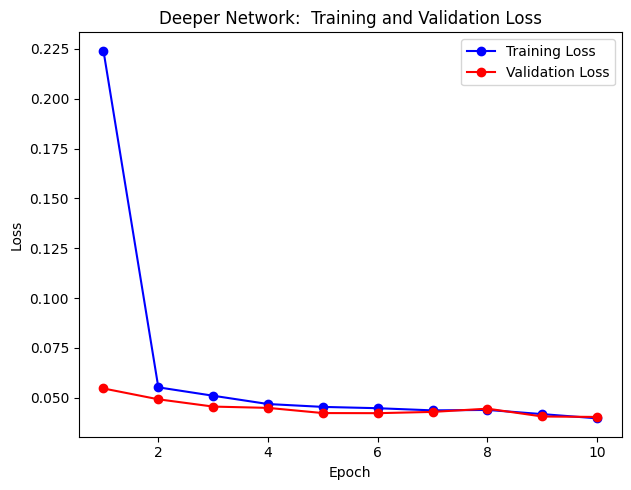

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


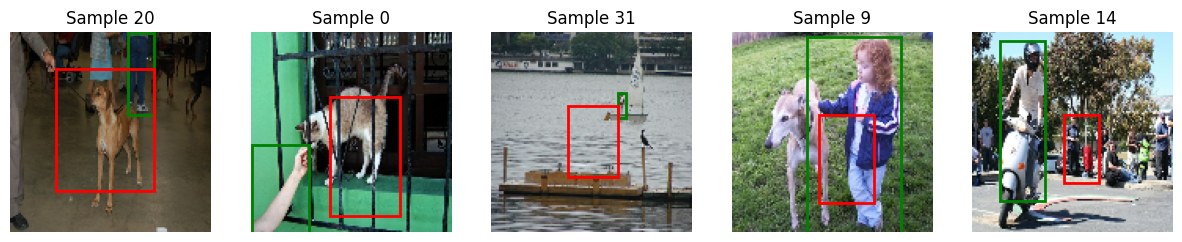

In [ ]:
def build_model_deep():

    model = models.Sequential([
        # First convolutional layer with 32 filters of size 3x3 and ReLU activation.
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional layer with 64 filters.
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional layer with 128 filters.
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Fourth convolutional layer with 256 filters.
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten the output from convolutional layers into a one-dimensional vector.
        layers.Flatten(),

        # Dense layer with 256 neurons to learn high-level features.
        layers.Dense(256, activation='relu'),

        # Output layer with 4 neurons for regressing [center_x, center_y, width, height].
        layers.Dense(4)
    ])
    return model

# Create the deeper model and print its summary for documentation.
model_deep = build_model_deep()
model_deep.summary()

# Compile the deeper model using the Adam optimizer and Mean Squared Error loss.
model_deep.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss='mse')

# Train the deeper model for a specified number of epochs using the training set,
# and validate it on the test set.
print("Training the deeper network model...")
epochs = 10  # Adjust the number of epochs as needed.
history_deep = model_deep.fit(ds_train, epochs=epochs, validation_data=ds_test)

# Visualize the training history (loss curves) for the deeper model.
plot_training_history(history_deep, "Deeper Network: ")

# Evaluate the deeper model's performance:
# Retrieve one batch from the test set and obtain predictions.
for images, true_bboxes in ds_test.take(1):
    preds_deep = model_deep.predict(images)
    break

# Randomly select 5 images from the batch for visualization.
num_images = 5
indices = random.sample(range(images.shape[0]), num_images)
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    ax = plt.subplot(1, num_images, i+1)
    plt.imshow(images[idx])

    # Convert true bounding box from [center_x, center_y, width, height] to
    # pixel coordinates [xmin, ymin, xmax, ymax] for visualization.
    cx, cy, w, h = true_bboxes[idx].numpy()
    xmin = (cx - w/2) * 128
    ymin = (cy - h/2) * 128
    xmax = (cx + w/2) * 128
    ymax = (cy + h/2) * 128
    rect_true = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                              fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect_true)

    # Convert predicted bounding box to pixel coordinates and draw as a red rectangle.
    pcx, pcy, pw, ph = preds_deep[idx]
    pxmin = (pcx - pw/2) * 128
    pymin = (pcy - ph/2) * 128
    pxmax = (pcx + pw/2) * 128
    pymax = (pcy + ph/2) * 128
    rect_pred = plt.Rectangle((pxmin, pymin), pxmax - pxmin, pymax - pymin,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect_pred)

    ax.set_title(f"Sample {idx}")
    ax.axis('off')
plt.show()



## Improvement Scheme 2 – Adding Batch Normalization and Dropout

By adding Batch Normalization layers (to speed up convergence and stabilize training) and Dropout layers (to reduce overfitting) to the model, the generalization ability of the model is improved, thereby improving the target detection effect.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,052 (12.61 MB)

 Trainable params: 3,305,604 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Training the BN + Dropout model...
Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 35.0550 - val_loss: 7.4863
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.4047 - val_loss: 23.4357
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.6598 - val_loss: 9.3094
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.3125 - val_loss: 2.7275
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.2708 - val_loss: 1.4285
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.2535 - val_loss: 0.5373
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2427 - val_loss: 0.2689
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.2286 - val_loss: 0.2206
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.2142 - val_loss: 0.2082
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.2080 - val_loss: 0.2044


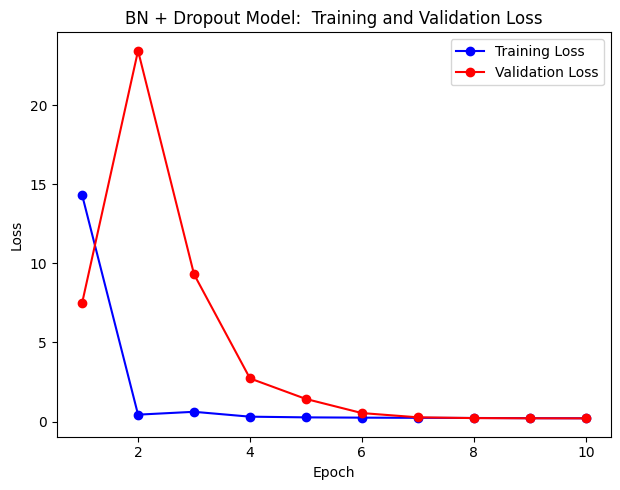

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


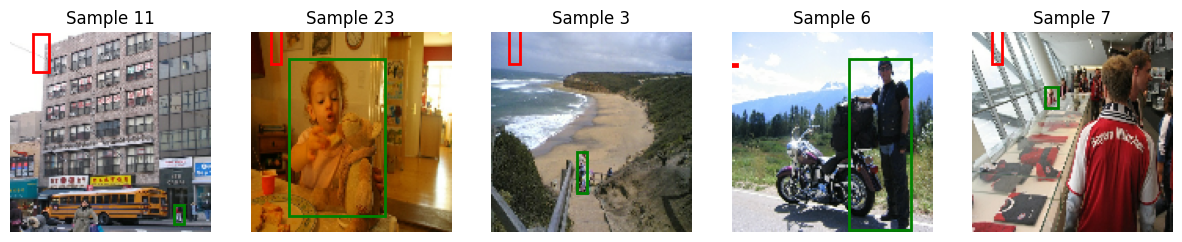

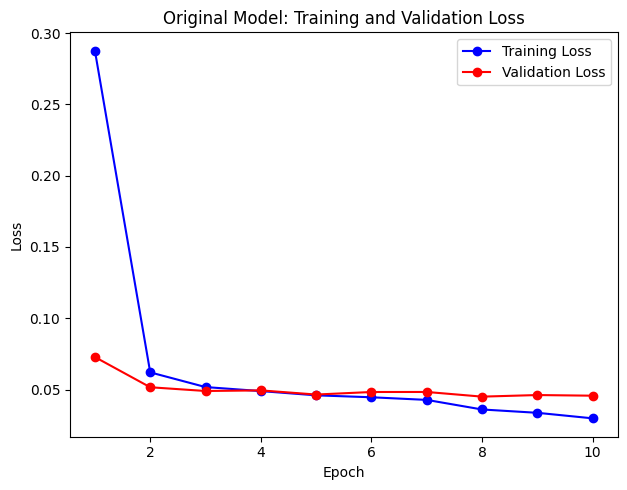

In [ ]:


def build_model_bn_dropout():

    model = models.Sequential([
        # First convolutional layer with 32 filters, followed by Batch Normalization.
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional layer with 64 filters, followed by Batch Normalization.
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional layer with 128 filters, followed by Batch Normalization.
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten the output to feed into the dense layers.
        layers.Flatten(),

        # Dense layer with 128 neurons and ReLU activation.
        layers.Dense(128, activation='relu'),

        # Apply Dropout with a rate of 0.5 to reduce overfitting.
        layers.Dropout(0.5),

        # Output layer with 4 neurons for bounding box regression.
        layers.Dense(4)
    ])
    return model

# Create the model with Batch Normalization and Dropout, and print its summary.
model_bn_dropout = build_model_bn_dropout()
model_bn_dropout.summary()

# Compile the BN + Dropout model using the Adam optimizer and MSE loss.
model_bn_dropout.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                         loss='mse')

# Train the BN + Dropout model.
print("Training the BN + Dropout model...")
history_bn_dropout = model_bn_dropout.fit(ds_train, epochs=epochs, validation_data=ds_test)

# Visualize the training history for the BN + Dropout model.
plot_training_history(history_bn_dropout, "BN + Dropout Model: ")

# Evaluate the BN + Dropout model:
# Retrieve one batch from the test set and get predictions.
for images, true_bboxes in ds_test.take(1):
    preds_bn_dropout = model_bn_dropout.predict(images)
    break

# Randomly select 5 images for visualization.
plt.figure(figsize=(15, 3))
indices = random.sample(range(images.shape[0]), num_images)
for i, idx in enumerate(indices):
    ax = plt.subplot(1, num_images, i+1)
    plt.imshow(images[idx])
    cx, cy, w, h = true_bboxes[idx].numpy()
    xmin = (cx - w/2) * 128
    ymin = (cy - h/2) * 128
    xmax = (cx + w/2) * 128
    ymax = (cy + h/2) * 128
    rect_true = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                              fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect_true)
    pcx, pcy, pw, ph = preds_bn_dropout[idx]
    pxmin = (pcx - pw/2) * 128
    pymin = (pcy - ph/2) * 128
    pxmax = (pcx + pw/2) * 128
    pymax = (pcy + ph/2) * 128
    rect_pred = plt.Rectangle((pxmin, pymin), pxmax - pxmin, pymax - pymin,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect_pred)
    ax.set_title(f"Sample {idx}")
    ax.axis('off')
plt.show()
#  Visualize Training History

def plot_training_history(history, title_prefix=""):

    # Retrieve the training and validation loss data from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(train_loss) + 1)

    # Create a figure for plotting
    plt.figure(figsize=(12, 5))

    # Plot training loss and validation loss curves side by side
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{title_prefix} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Plot the training history using the history object obtained during model training.
plot_training_history(history, "Original Model:")